## Imports

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [2]:
LabelDict = {'chirp_mass' : r"$\mathcal{M} [M_\odot]$", 'mass_ratio' : r"$q$", \
             'a_1' : r"$a_1$", 'a_2' : r"$a_2$", 'luminosity_distance' : r"$d_L$ [mpc]", \
            'dec' : 'dec', 'ra' : 'ra', 'theta_jn' : r"$\theta_{jn}$", 'tilt_1' : r"$\theta_1$", \
            'tilt_2' : r"$\theta_2$"}
    
def GetTruthDict(p):
    """ Return a dictionary of truth values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    print(params)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    f.close()
    return TruthDict


def Evidence(p):
    """ Return the log evidence from a given bilby run """
    f = open(p + 'outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence']

def EvidenceErr(p):
    """ Return the error on the log evidence from a given bilby run """
    f = open(p + 'outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence_err']

def BayesFactor(p):
    """ Return the log Bayes factor form a given bilby run """
    f = open(p + 'outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor']

def GetPosterior(p, quantity):
    """ Return the posterior for a given bilby run
        for a given quantity, such as mass_ratio, 
        chirp_mass, a_1, a_2, etc"""
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    vals = data['posterior']['content'][quantity]
    f.close()
    return vals

def EllinKm(ell_string, mass):
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    return phys_ell_km.value

In [30]:
ell = ["0p0", "0p15", "0p2", "0p3", "0p35", "0p37"]
ell_km = np.array([EllinKm(l, 68) for l in ell])**4
bfs = [BayesFactor("../BilbyPE/dCS_" + l + "/") for l in ell]
evs = [Evidence("../BilbyPE/dCS_" + l + "/") for l in ell]
ev_errs = [EvidenceErr("../BilbyPE/dCS_" + l + "/") for l in ell]


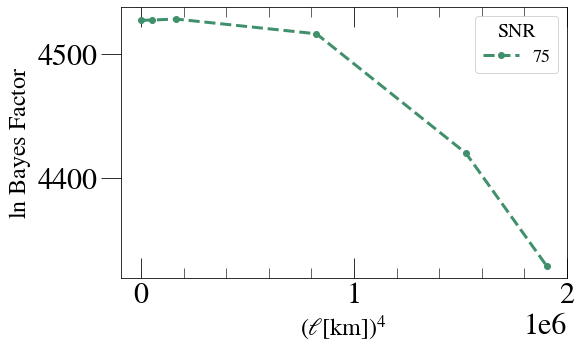

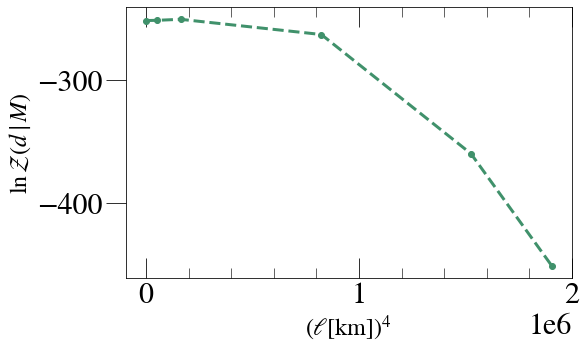

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(ell_km, bfs, '--o', color = '#40916b', lw = 3.0, label = '75')
plt.xlabel(r'$(\ell [\mathrm{km}])^4$')
plt.ylabel(r'$\ln$ Bayes Factor')
legend = plt.legend(title = 'SNR')
plt.setp(legend.get_title(),fontsize=20)

plt.figure(figsize=(8, 5))
plt.errorbar(ell_km, evs, ev_errs, ls = '--', color = '#40916b', lw = 3.0, label = '75')
plt.plot(ell_km, evs, 'o', color = '#40916b')
plt.xlabel(r'$(\ell [\mathrm{km}])^4$')
plt.ylabel(r'$\ln \,\mathcal{Z} (d \mid M)$')
plt.show()

In [184]:
def PlotMassRatioPosteriors():
    
    def histogram(p, label, color):
        data = GetPosterior(p, 'mass_ratio')
        nbins = 20
        H = plt.hist(data, alpha=1.0, color = color, linewidth=2.0, histtype=u'step', density=True, bins = nbins, label=p)
        
    plt.figure(figsize=(10,6))
    
    cs = sns.color_palette('Paired', n_colors=5)
    histogram('../BilbyPE/Surrogate_FramesSearch/outdir', 'reg', cs[0])
    histogram('../BilbyPE/Surrogate_FramesSearch25Hz/outdir', 'with spin', cs[1])
    histogram('../BilbyPE/Surrogate_FramesSearchNoise/outdir', 'closer', cs[2])
    #histogram('../BilbyPE/Surrogate_FramesMass/outdir', 'just masses', cs[3])
    
    plt.legend(loc='best', ncol=1, fontsize=18)
    plt.ylabel('Posterior distribution')
    plt.xlabel('$q$')
    plt.tight_layout()
    plt.show()

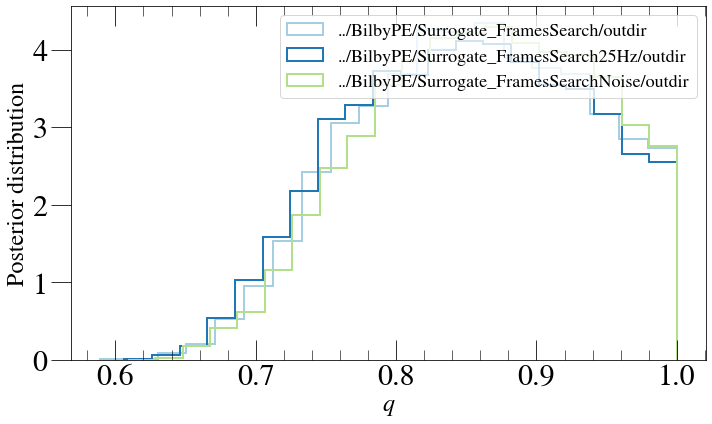

In [185]:
PlotMassRatioPosteriors()

In [ ]:
def CornerPlot():
    
    ## Quantities to plot
    quants = ['mass_ratio', 'chirp_mass', 'a_1', 'a_2']
    q_range = [(0.6, 1.0), (28, 32), (0.0, 1.0), (0.0, 1.0)]
    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 

    ## dCS values to plot
    SNR = '75'
    dcs_values = ["0p25", "0p3", "0p35", "0p37"]
    cs = sns.color_palette('magma', n_colors=len(dcs_values) + 1)

    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]

    ## Plot GR values
    p_gr = '../BilbyPE/dCS_0p0_' + SNR + '/'
    TruthDict = GetTruthDict(p_gr + 'Frames_dCS') ## for now
    truths = [TruthDict[q] for q in quants]
    mass = TruthDict['mass']
    vals_gr = np.vstack([GetPosterior(p_gr + 'outdir', q) for q in quants]).transpose()

    corner.corner(vals_gr, fig=fig, labels=labels,
                  title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=cs[0],
                  show_titles=False, smooth = 3.0, truths = truths, truth_color = 'black', range = q_range)
    l_gr = ax_arr[0][dim-1].plot(x, y, label='%.1f [GR]' % EllinKm("0p0", mass), color = cs[0])
    handles = [l_gr[0]]

    ## Plot dCS values
#     for ell, color in zip(dcs_values, cs[1:]):

#         p = '../BilbyPE/dCS_' + ell + '_' + SNR + '/'
#         vals = np.vstack([GetPosterior(p + 'outdir', q) for q in quants]).transpose()

#         corner.corner(vals, fig=fig, labels=labels,
#                      title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, 
#                       show_titles=False, smooth = 3.0)

#         l = ax_arr[0][dim-1].plot(x, y, label='%.1f' % EllinKm(ell, mass), color = color)
#         handles.append(l[0])


    ## add in the legend
    legend = ax_arr[0][dim-1].legend(handles=handles, frameon=False, title = r'$\ell$ [km]', loc = 'upper center')
    plt.setp(legend.get_title(),fontsize=20)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    #plt.savefig('BilbySurrogate.pdf')
    plt.show()
    
CornerPlot()  

{'a_1': [0, 0, 0.329892752405], 'a_2': [0, 0, -0.439940981499], 'mass_ratio': 0.8188310079446952, 'chirp_mass': 29.422167356249002, 'dt': 0.00048828125, 't_gps': 1126259462.0, 'peak_time_in_segment': 8.0, 'segment_length': 16.0, 'dist_mpc': 405.7935217454469, 'mass': 68.0, 'q': 1.2212532137858916, 'chiA': [0, 0, 0.329892752405], 'chiB': [0, 0, -0.439940981499], 'f_low': 0, 'theta': 3.141592653589793, 'phi': 0, 'ra': 1.952318922, 'dec': -1.26967171703, 'pol': 0.824043851821, 'source': 'Waveforms/Lev5/dCS_Strain_0p0.h5', 'H_SNR': 75.0, 'L_SNR': 57.84123272985948}


### Minimum frequency analysis

for configuration:

mass_ratio = 1.0
chirp_mass = 20.0
a_1 = 0.99
a_2 = 0.99
tilt_1 = 0.0
tilt_2 = 3.14159265359
phi_12 = 0.0
phi_jl = 0.0


[-0.00619826  0.90947773  0.33385222]


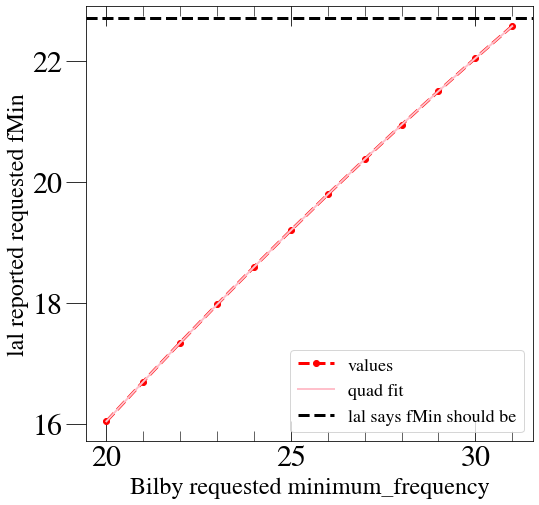

In [26]:
my_fmin = [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]
ls_fmin = [16.04293095, 16.69953829, 17.34314270, 17.97386363, 18.59182733, 19.19716692, 19.79002226, 20.37053975, \
          20.93887207, 21.49517785, 22.03962128, 22.57237175]
fmin_should = 22.70617355 
fit = np.polyfit(my_fmin, ls_fmin, 2)
print(fit)
p = np.poly1d(fit)

plt.figure(figsize=(8,8))

plt.plot(my_fmin, ls_fmin, '--o', color='red', label = 'values')
plt.plot(my_fmin, p(my_fmin), label = 'quad fit', lw = 2.0, color = 'pink')

plt.xlabel('Bilby requested minimum_frequency')
plt.ylabel('lal reported requested fMin')

plt.axhline(fmin_should, color='black', ls = '--', label = 'lal says fMin should be')

plt.legend()

plt.show()

